In [1]:
import numpy as np
import datetime as dt
import logging
import seaborn as sns
import matplotlib.pyplot as plt
from import_sql import *

## Run Parameters

In [2]:
recreate_base_tables=False
#rolling window
n=12
# params to group by
dims=['ACCOUNT_CLASS',
        'FIRST_PRODUCT_CATEGORY',
        # 'PS_INDICATOR',
        'COHORT_YM',
        'COUNTRY'
]

In [3]:
if recreate_base_tables:
    # create table of fees from MP. SQL from Temma
    create_sf_table(create_kpi_mp_fee_text)
    # create table of KPI base, no summarization
    create_sf_table(create_kpi_base_text)
    # create dimension table for ease of joins
    ## don't need if analyzing in pandas
    create_sf_table(create_kpi_dim_text)

In [4]:
print(create_kpi_base_text)


CREATE OR REPLACE TABLE PRODUCT_ANALYTICS.KPI_BASE AS
SELECT O.NAME,
        O.ACCOUNT_CLASS__C,
        O.CLASS__C,
        -- CLOSEDATE IS THE INDICATOR FOR ACTIVITY TO SIGNAL A NEW CUSTOMER OR ACTIVE CUSTOMER
        --  FOR PRESEASON, WE TAKE THE FUNDING DATE, FOR OTHERS WE USE THE CLOSEDATE
        IFF(O.RECORD_TYPE_NAME__C = 'PreSeason',O.FUNDING_DATE__C,O.CLOSEDATE) AS ACTIVITY_DATE,
        O.FUNDING_DATE__C,
        O.CLOSED_WON_DATE__C,
        O.CONTRACT_TYPE__C,
        O.CONTRACT_SHIP_DATE__C,
        --GMV
        COALESCE(F.ESTIMATED_GMV, O.GMV__C,O.FORECASTED_GMV__C) AS GMV,
        F.TOTAL_GMV,
        --REVENUE
        NVL(F.TOTAL_BASE_FEES,0)+NVL(F.TOTAL_LATE_FEES,0)+NVL(F.BUYER_MARKETPLACE_FEE,0)+NVL(F.SELLER_MARKETPLACE_FEE,0)+NVL(F.ADMIN_FEE_T,0) AS F_REVENUE,
        NVL(PSAR.COMMISSION,0) + NVL(PSAR.LATE_FEES,0) + NVL(PSAR.APP_FEE,0) AS PS_REVENUE,
        IFF(PS_REVENUE>0, PS_REVENUE, F_REVENUE) AS REVENUE,
        --
        O.ISCLOSED,
        DATE_TRUNC('MO

In [5]:
# get the data at a month, account class, product, cohort year, country level
kpi_b = get_sf_data('SELECT * FROM PROD_ANALYTICS.PRODUCT_ANALYTICS.KPI_BASE')
kpi_b['ACTIVITY_DATE'] = pd.to_datetime(kpi_b['ACTIVITY_DATE'])
kpi_b['FIRST_CLOSEDATE'] = pd.to_datetime(kpi_b['FIRST_CLOSEDATE'])

Table Fetched


---
## Account Rollups

In [6]:
# Resample to monthly frequency and mark each user as active
monthly_active = kpi_b.groupby(by=['ACCOUNTID']+dims).resample('MS', on='ACTIVITY_DATE').size().unstack(fill_value=0)
monthly_active = (monthly_active > 0).astype(int)  # Mark the user as active (1) or not (0) for each month

## Retained Accounts

In [7]:
# Calculate rolling 12-month activity window, excluding the current month
## Have to transpose and back to using rolling across colums.
## Max makes it one or zero, instead of summing
monthly_rollup = monthly_active.T.rolling(window=n+1, min_periods=1).max().shift(0).T #do we want the shift here? exclude current month?
# get a yearly rollup for visualizations
yearly_rollup = monthly_rollup.T.resample('YS').max().T

In [8]:
x=monthly_rollup.groupby(by=dims).sum().T
retained=x.melt(ignore_index=False, value_name='RETAINED_ACCOUNTS')
retained['RETAINED_ACCOUNTS']=retained.RETAINED_ACCOUNTS.astype(int)
del x

## Churned Accounts

In [9]:
churned_users=monthly_rollup.apply(
    lambda x: [1 if x[col] == 0 and x.shift(periods=1,axis=0)[col]==1 else 0 for col in monthly_rollup.columns], axis=1)
monthly_churn=pd.DataFrame(churned_users.to_list(), index=monthly_rollup.index, columns=monthly_rollup.columns)

In [10]:
x=monthly_churn.groupby(by=dims).sum().T
churned=x.melt(ignore_index=False, value_name='CHURNED_ACCOUNTS')
del x

## New Accounts

In [11]:
# take monthly active, and make =1 if it's the first occurence of activity
new_users=monthly_active.apply(
    lambda x: [1 if x[col]==1 and col==x.idxmax() else 0 for col in monthly_active.columns], axis=1)
# make a dataframe with same dimensions as monthly rollup
monthly_new=pd.DataFrame(new_users.to_list(), index=monthly_active.index, columns=monthly_active.columns)

In [12]:
x=monthly_new.groupby(by=dims).sum().T
new=x.melt(ignore_index=False, value_name='NEW_ACCOUNTS')
del x

In [13]:
new['NEW_ACCOUNTS_ROLLING']=new.NEW_ACCOUNTS.rolling(window=n, min_periods=1).sum().astype(int)

### Combine Them

In [14]:
qout=retained.merge(
    churned, on=['ACTIVITY_DATE']+dims, how='left'
    ).merge(
        new, on=['ACTIVITY_DATE']+dims, how='left')
# qout.info()

In [15]:
qout['RETAINED ACCOUNTS (ROLLING WINDOW, NO NEW)']=qout.RETAINED_ACCOUNTS - qout.NEW_ACCOUNTS

---
## GMV

In [16]:
## Get GMV by index 
gmv_s=kpi_b.groupby(by=['ACCOUNTID']+dims).GMV.sum().fillna(0.00)

### Active

In [17]:
# Monthly rollup will have a '1' for each month that is considered active. This will replace these 1s with the value of the index's GMV
gmv_active_df=monthly_rollup.multiply(gmv_s, axis=0)
# sum across accounts
x=gmv_active_df.groupby(by=dims).sum().T
# melt and calculate retained GMV
retained_gmv=x.melt(ignore_index=False, value_name='RETAINED_GMV')
del x
# retained_gmv.head()

### New

In [18]:
# Monthly rollup will have a '1' for each month that is considered active. This will replace these 1s with the value of the index's GMV
gmv_new_df=monthly_new.multiply(gmv_s, axis=0)
# sum across accounts
x=gmv_new_df.groupby(by=dims).sum().T
# melt and calculate retained GMV
new_gmv=x.melt(ignore_index=False, value_name='NEW_GMV')
del x
# new_gmv.head()

### Churned

In [19]:
# Monthly rollup will have a '1' for each month that is considered active. This will replace these 1s with the value of the index's GMV
gmv_churn_df=monthly_churn.multiply(gmv_s, axis=0)
# sum across accounts
x=gmv_churn_df.groupby(by=dims).sum().T
# melt and calculate retained GMV
churn_gmv=x.melt(ignore_index=False, value_name='CHURNED_GMV')
del x
# churn_gmv.head()

### Combine them

In [20]:
## GMV
### Combine Them
gmv_out=retained_gmv.merge(
    churn_gmv, on=['ACTIVITY_DATE']+dims, how='left'
    ).merge(
        new_gmv, on=['ACTIVITY_DATE']+dims, how='left')
gmv_out['RETAINED GMV (NO NEW)']=gmv_out.RETAINED_GMV - gmv_out.NEW_GMV

---
## Revenue

In [21]:
## Get GMV by index 
rev_s=kpi_b.groupby(by=['ACCOUNTID']+dims).REVENUE.sum().fillna(0.00)

### Active

In [22]:
# Monthly rollup will have a '1' for each month that is considered active. This will replace these 1s with the value of the index's GMV
rev_active_df=monthly_rollup.multiply(rev_s, axis=0)
# sum across accounts
x=rev_active_df.groupby(by=dims).sum().T
# melt and calculate retained GMV
retained_rev=x.melt(ignore_index=False, value_name='RETAINED_REV')
del x

### New

In [23]:
# Monthly rollup will have a '1' for each month that is considered active. This will replace these 1s with the value of the index's GMV
rev_new_df=monthly_new.multiply(rev_s, axis=0)
# sum across accounts
x=rev_new_df.groupby(by=dims).sum().T
# melt and calculate retained GMV
new_rev=x.melt(ignore_index=False, value_name='NEW_REV')
del x

### Churned

In [24]:
# Monthly rollup will have a '1' for each month that is considered active. This will replace these 1s with the value of the index's GMV
rev_churn_df=monthly_churn.multiply(rev_s, axis=0)
# sum across accounts
x=rev_churn_df.groupby(by=dims).sum().T
# melt and calculate retained GMV
churn_rev=x.melt(ignore_index=False, value_name='CHURNED_REV')
del x

### Combine them

In [25]:
## REV
### Combine Them
rev_out=retained_rev.merge(
    churn_rev, on=['ACTIVITY_DATE']+dims, how='left'
    ).merge(
        new_rev, on=['ACTIVITY_DATE']+dims, how='left')
rev_out['RETAINED REV (NO NEW)']=rev_out.RETAINED_REV - rev_out.NEW_REV

In [26]:
new_churn_query_v2=qout.merge(
    gmv_out, on = ['ACTIVITY_DATE']+dims, how = 'left').merge(
        rev_out, on = ['ACTIVITY_DATE']+dims, how = 'left')

---
## Outputs

In [27]:
## overall summarize query
new_churn_query_v2.to_csv('NEW_CHURN_QUERY_V2.csv', index=True)

In [28]:
## could just export yearly rollup for these?

## yearly by size
retained_ys=export_by_dim(
    yearly_rollup, gb_dims=dims[0], value_name='RETAINED_ACCOUNTS', out_name='CLOSEYR-SIZE-V2.csv')
## yearly by product
retained_yp=export_by_dim(
    yearly_rollup, gb_dims=dims[1], value_name='RETAINED_ACCOUNTS', out_name='CLOSEYR-PRODUCT-V2.csv')
## yearly by cohort
retained_y = export_by_dim(
    yearly_rollup, gb_dims=dims[2], value_name='RETAINED_ACCOUNTS', out_name='CLOSEYR-COHORT-V2.csv')
## yearly by country
retained_c=export_by_dim(
    yearly_rollup, gb_dims=dims[3], value_name='RETAINED_ACCOUNTS', out_name='CLOSEYR-GEO-V2.csv')

In [29]:
# sample rows of trading only
to_accounts=kpi_b[kpi_b['FIRST_PRODUCT_CATEGORY']=='TRADING ONLY'].ACCOUNTID.unique()
to_accounts_sample=np.random.choice(to_accounts,3)
kpi_b[kpi_b.ACCOUNTID.isin(to_accounts_sample)].sort_values(by='ACCOUNTID').to_csv('trading_only_examples.csv', index=False)

In [30]:
## Count by unique product+account, not just one product per account
# Resample to monthly frequency and mark each user as active
monthly_active_pl = kpi_b.groupby(by=['ACCOUNTID','PRODUCT_LABEL_CATEGORY']).resample('MS', on='ACTIVITY_DATE').size().unstack(fill_value=0)
monthly_active_pl = (monthly_active_pl > 0).astype(int)  # Mark the user as active (1) or not (0) for each month
# Calculate rolling 12-month activity window, excluding the current month
## Have to transpose and back to using rolling across colums.
## Max makes it one or zero, instead of summing
monthly_rollup_pl = monthly_active_pl.T.rolling(window=n+1, min_periods=1).max().shift(0).T #do we want the shift here? exclude current month?
# get a yearly rollup for visualizations
yearly_rollup_pl = monthly_rollup_pl.T.resample('YS').max().T

x=yearly_rollup_pl.groupby(by='PRODUCT_LABEL_CATEGORY').sum().T
y=x.melt(ignore_index=False, value_name='RETAINED_ACCOUNTS')
y['RETAINED_ACCOUNTS']=y['RETAINED_ACCOUNTS'].astype(int)
y.to_csv('CLOSEYR-ALLPRODUCT-V2.csv', index=True)
y.head()
del x,y

In [31]:
## CLOSEYR-NUMPRODUCTS
numprod=kpi_b.groupby(by=['ACCOUNTID','CLOSED_YEAR']).PRODUCT_LABEL.nunique()
numprod.to_csv('CLOSEYR-NUMPRODUCTS.csv', index=True)

In [32]:
# ## yearly by PS Indicator
# ## 
# #****must have run with appropriate dims above: ['ACCOUNT_CLASS', 'PS_INDICATOR', 'COHORT_YM', 'COUNTRY'] to produce proper yearly rollup
# print(dims[1:3])
# retained_yps = export_by_dim(
#     yearly_rollup, gb_dims=dims[1:3], value_name='RETAINED_ACCOUNTS', out_name='CLOSEYR-PS_IND-V2.csv'
# )

## Plotting

In [33]:
bar_df=new_churn_query_v2.groupby(by='ACTIVITY_DATE').agg({
    'RETAINED ACCOUNTS (ROLLING WINDOW, NO NEW)':'sum',
    'CHURNED_ACCOUNTS':'sum'
})
bar_df['Churn Rate'] = bar_df['CHURNED_ACCOUNTS']/bar_df['RETAINED ACCOUNTS (ROLLING WINDOW, NO NEW)']
bar_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2015-08-01 to 2024-05-01
Data columns (total 3 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   RETAINED ACCOUNTS (ROLLING WINDOW, NO NEW)  106 non-null    int64  
 1   CHURNED_ACCOUNTS                            106 non-null    int64  
 2   Churn Rate                                  105 non-null    float64
dtypes: float64(1), int64(2)
memory usage: 3.3 KB


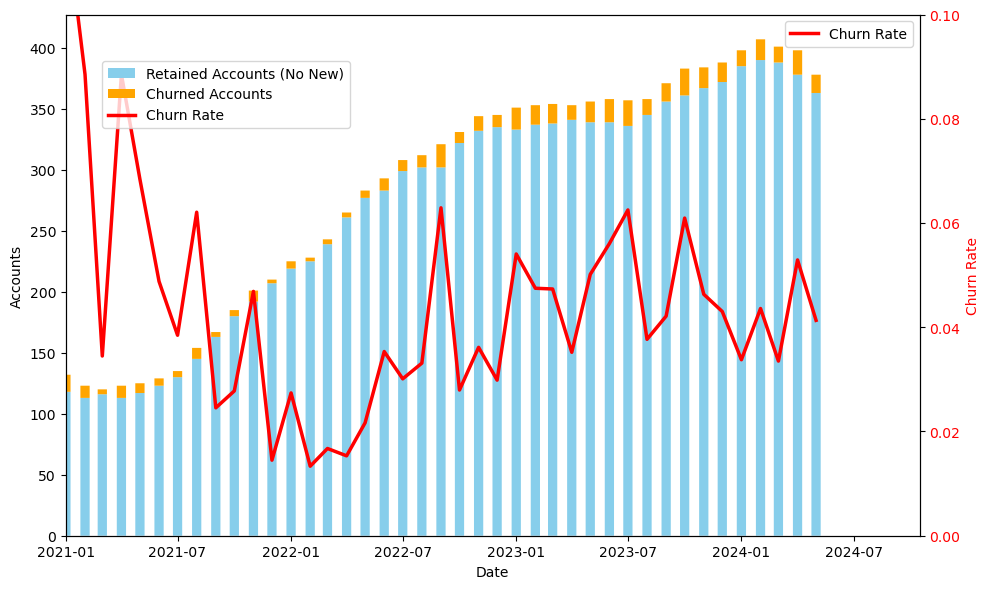

In [34]:
# Create figure and axis for the bar chart
fig, ax1 = plt.subplots(figsize=(10, 6))
# Plot each segment
plt.bar(bar_df.index, bar_df['RETAINED ACCOUNTS (ROLLING WINDOW, NO NEW)'], color='skyblue', label='Retained Accounts (No New)', width=15, snap=False)
plt.bar(bar_df.index, bar_df['CHURNED_ACCOUNTS'], bottom=bar_df['RETAINED ACCOUNTS (ROLLING WINDOW, NO NEW)'], color='orange', label='Churned Accounts', width=15, snap=False)

ax1.set_xlabel('Date')
ax1.set_ylabel('Accounts', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlim(pd.to_datetime('2021-01-01',format='%Y-%m-%d'))

# Create a second y-axis for the line plot
ax2 = ax1.twinx()
# Overlay a line plot
sns.lineplot(data=bar_df['Churn Rate'], markers=True, dashes=False, color='red', linewidth=2.5, label='Churn Rate')

ax2.set_ylabel('Churn Rate', color='red')
ax2.tick_params(axis='y', labelcolor='red')
ax2.set_ylim(0,0.10)

# Add legend and title
fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))
# plt.title('Churn Rate with '+ n.astype(str) +' rolling window')

plt.show()